In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [6]:
pwd

'/home/snikolenko/soft/harbourspace-ml/rodrigo'

In [7]:
path = '../data/nlp/'
train = '20news-bydate-train'
test = '20news-bydate-test'

In [8]:
# Load test directories
test_directories = os.listdir(path + test)
test_directories

['rec.motorcycles',
 'sci.electronics',
 'sci.med',
 'rec.sport.hockey',
 'comp.sys.mac.hardware',
 'talk.politics.misc',
 'sci.space',
 'talk.politics.mideast',
 'comp.windows.x',
 'comp.sys.ibm.pc.hardware',
 'comp.os.ms-windows.misc',
 'sci.crypt',
 'rec.sport.baseball',
 'misc.forsale',
 'alt.atheism',
 'rec.autos',
 'soc.religion.christian',
 'talk.religion.misc',
 'talk.politics.guns',
 'comp.graphics']

In [9]:
# Load train directories
train_directories = os.listdir(path + train)
train_directories

['rec.motorcycles',
 'sci.electronics',
 'sci.med',
 'rec.sport.hockey',
 'comp.sys.mac.hardware',
 'talk.politics.misc',
 'sci.space',
 'talk.politics.mideast',
 'comp.windows.x',
 'comp.sys.ibm.pc.hardware',
 'comp.os.ms-windows.misc',
 'sci.crypt',
 'rec.sport.baseball',
 'misc.forsale',
 'alt.atheism',
 'rec.autos',
 'soc.religion.christian',
 'talk.religion.misc',
 'talk.politics.guns',
 'comp.graphics']

In [10]:
os.listdir(path + test + '/' + test_directories[0])[:10]

['105561',
 '104825',
 '104857',
 '105101',
 '104823',
 '105120',
 '105128',
 '104894',
 '105215',
 '104748']

In [11]:
os.listdir(path + train + '/' + test_directories[0])[:10]

['104718',
 '104383',
 '103187',
 '104318',
 '103121',
 '104559',
 '104934',
 '104333',
 '104565',
 '104459']

## First, let's just understand how the files are structured... 

In [14]:
a_doc = '../data/nlp/20news-bydate-train/alt.atheism/51147'

In [15]:
with open(a_doc) as file:
    for line in file:
        print(line)

Subject: Re: Ancient islamic rituals

From: livesey@solntze.wpd.sgi.com (Jon Livesey)

Organization: sgi

NNTP-Posting-Host: solntze.wpd.sgi.com

Lines: 20



In article <1993Apr3.081052.11292@monu6.cc.monash.edu.au>, darice@yoyo.cc.monash.edu.au (Fred Rice) writes:

>

>  I propose that these two trends -- greater level of general 

> depression in society (and other psychological problems) and 

> greater sexual promiscuity -- are linked, with the latter being 

> a prime cause of the former.  I cannot provide any evidence beyond 

> this at this stage, but the whole thesis seems very reasonable to 

> me and I request that people ponder upon it.



I pondered it for all of ten seconds when I realised that since

we don't have any reliable statistics for sexual promiscuity,

and since the whole issue of "depression" isn't at all well 

defined for earlier centuries, you are probably talking crap.



Of course, you could pull a Mozumder on us, and say that people

who are having sex o

In [18]:
another_doc = '../data/nlp/20news-bydate-train/alt.atheism/53158'

In [19]:
with open(another_doc) as file:
    for line in file:
        print(line)

From: dfuller@portal.hq.videocart.com (Dave Fuller)

Subject: Re: thoughts on christians

Organization: VideOcart Inc.

X-Newsreader: Tin 1.1 PL3

Lines: 40



cmtan@iss.nus.sg (Tan Chade Meng - dan) writes:

: 

[ . . . . . ]

:

: Personally, I feel that since religion have such a poweful

: psychological effect, we should let theists be.  But the problem is that

: religions cause enormous harm to non-believers and to humanity as a whole

: (holy wars, inquisitions, inter-religious hatred, impedence of science

: & intellectual progress, us-&-them attitudes etc etc.  Need I say more?).

: I really don't know what we can do about them.  Any comments?

: 



  I have always held that there should be no attempt to change a persons

attitude or lifestyle as long as it makes them happy and does not tax

anybody else. This seems to be ok for atheists. You don't get an atheist

knocking on your door, stopping you in the airport, or handing out

literature at a social event. Theists seem to

In [21]:
yet_another_doc = '../data/nlp/20news-bydate-train/alt.atheism/53753'

In [22]:
with open(another_doc) as file:
    for line in file:
        print(line)

From: dfuller@portal.hq.videocart.com (Dave Fuller)

Subject: Re: thoughts on christians

Organization: VideOcart Inc.

X-Newsreader: Tin 1.1 PL3

Lines: 40



cmtan@iss.nus.sg (Tan Chade Meng - dan) writes:

: 

[ . . . . . ]

:

: Personally, I feel that since religion have such a poweful

: psychological effect, we should let theists be.  But the problem is that

: religions cause enormous harm to non-believers and to humanity as a whole

: (holy wars, inquisitions, inter-religious hatred, impedence of science

: & intellectual progress, us-&-them attitudes etc etc.  Need I say more?).

: I really don't know what we can do about them.  Any comments?

: 



  I have always held that there should be no attempt to change a persons

attitude or lifestyle as long as it makes them happy and does not tax

anybody else. This seems to be ok for atheists. You don't get an atheist

knocking on your door, stopping you in the airport, or handing out

literature at a social event. Theists seem to

### Ok, so they all seem to have the text starting right after the "Lines"  line, let's try to load one text in a quick and dirty way

In [23]:
def read_doc(doc, category):
    
    with open(doc) as file:

        info = {}
        text = ''
        reached_lines = False
        
        try:
            for line in file:
                line = line.replace('\n', ' ').replace('\t', ' ')
                if not reached_lines:
                    if 'From:' in line:
                        info['from'] = line
                    elif 'Subject:' in line:
                        info['subject'] = line
                    elif 'Organization' in line:
                        info['organization'] = line
                    elif 'Lines:' in line:
                        reached_lines = True
                else:
                    text += line
        except UnicodeDecodeError:
            pass

        
        info['text'] = text
        info['category'] = category

    return info

## Let's test reading a doc

In [24]:
read_doc(a_doc, 'atheism')

{'category': 'atheism',
 'from': 'From: livesey@solntze.wpd.sgi.com (Jon Livesey) ',
 'organization': 'Organization: sgi ',
 'subject': 'Subject: Re: Ancient islamic rituals ',
 'text': ' In article <1993Apr3.081052.11292@monu6.cc.monash.edu.au>, darice@yoyo.cc.monash.edu.au (Fred Rice) writes: > >  I propose that these two trends -- greater level of general  > depression in society (and other psychological problems) and  > greater sexual promiscuity -- are linked, with the latter being  > a prime cause of the former.  I cannot provide any evidence beyond  > this at this stage, but the whole thesis seems very reasonable to  > me and I request that people ponder upon it.  I pondered it for all of ten seconds when I realised that since we don\'t have any reliable statistics for sexual promiscuity, and since the whole issue of "depression" isn\'t at all well  defined for earlier centuries, you are probably talking crap.  Of course, you could pull a Mozumder on us, and say that people who 

### Looks ok, so let's load all the documents... 

In [25]:
def read_docs(directories, train_test):
    docs = []
    for i, category in enumerate(directories):
        path_to_doc = path + train_test + '/' + directories[i] 
        for doc_name in os.listdir(path_to_doc):
            docs.append(read_doc(path_to_doc + '/' + doc_name, category))
    return docs   

In [26]:
test_docs = read_docs(test_directories, test)
train_docs = read_docs(train_directories, train)

In [27]:
# Sample test document
test_docs[500]

{'category': 'sci.electronics',
 'from': 'From: katop@astro.ocis.temple.edu (Chris Katopis) ',
 'organization': 'Organization: Temple University ',
 'subject': 'Subject: Phantoms in my Sony STRVX550 Receiver ',
 'text': 'Nntp-Posting-Host: astro.ocis.temple.edu X-Newsreader: TIN [version 1.1 PL8]   While I have gotten 8-9 years out of this digital receiver, it has been acting VERRY strange of late.  I hope that  the following  symptoms may help someone diagnose the error:  - i know that whatever lithium memory backup it had - has long died thus if i unplug it - it won\'t remember the presets  - it has given up listening to the remote.  (i tried changing the remote\'s batteries) when i try a remote function - the receiver registers that it received it (a green remote light flashes) but the right function doesn\'t happen - if any function at all.  (also strange- when i hit  the "mute" button, for example, the display panel goes black - yikes-  i\'ve never seen that before ...)  - before 

In [28]:
# Sample train document
train_docs[500]

{'category': 'rec.motorcycles',
 'from': 'From: speedy@engr.latech.edu (Speedy Mercer) ',
 'organization': 'Organization: Louisiana Tech University ',
 'subject': 'Subject: Re: Boom! Dog attack! ',
 'text': "NNTP-Posting-Host: bhm116e-spc.engr.latech.edu  In article <csundh30.734975106@ursa> csundh30@ursa.calvin.edu (Charles Sundheim) writes:  <tale of bike-eating-devil-dog deleted>  >Moral: I'm not really sure, but more and more I believe that bikers ought  >       to be allowed to carry handguns.  Come to Louisiana where it is LEGAL to carry concealed weapons on a bike!   ----===== DoD #8177 = Technician(Dr. Speed) .NOT. Student =====----                            Stolen Taglines...               * God is real, unless declared integer. *             * I came, I saw, I deleted all your files. *          * Black holes are where God is dividing by zero. *         * The world will end in 5 minutes. Please log out. *        * Earth is 98% full.... please delete anyone you can. * "}

In [29]:
len(test_docs)

7532

In [30]:
len(train_docs)

11314

In [31]:
test_df = pd.DataFrame(test_docs)
train_df = pd.DataFrame(train_docs)

In [32]:
test_df.shape

(7532, 5)

In [33]:
train_df.shape

(11314, 5)

In [34]:
test_df.head()

,category,from,organization,subject,text
0,rec.motorcycles,From: hartzler@cbmvax.cbm.commodore.com (Jerry...,"Organization: Commodore, West Chester, PA",Subject: Re: story & respect,In article <1993Apr23.220259.12375@Pacesetter...
1,rec.motorcycles,From: binger@hsh.com,Organization: HSH Associates,Subject: Re: Wanted: Advice for New Cylist,In article <1993Apr20.150337.2963@rd.hydro.on...
2,rec.motorcycles,From: kenm@array.com (Ken Murphy),"Organization: Array Microsystems, Colorado Spr...",Subject: Re: Death of a 2 stroke - why did it ...,X-Newsreader: TIN [version 1.1 PL8] Zebee Joh...
3,rec.motorcycles,From: erika@znext.cts.com (erik astrup),Organization: pnet,Subject: Re: What octane ?,jnmoyne@lbl.gov (Jean-Noel Moyne) writes: : ...
4,rec.motorcycles,From: tcora@pica.army.mil (Tom Coradeschi),"Organization: Elect Armts Div, US Army Armt RD...","Subject: Re: So, do any XXXX, I mean police of...",Nntp-Posting-Host: b329-gator-1.pica.army.mil ...


In [35]:
train_df.head()

,category,from,organization,subject,text
0,rec.motorcycles,From: harmons@.WV.TEK.COM (Harmon Sommer),NaN,Subject: Re: Countersteering_FAQ please post,Sender: Reply-To: harmons@gyro.WV.TEK.COM (H...
1,rec.motorcycles,From: howland@noc.arc.nasa.gov (Curt Howland),Organization: NASA Science Internet Project Of...,Subject: Re: dogs,In article <MS-C.735160298.1147902781.mrc@Ikk...
2,rec.motorcycles,From: todd@psgi.UUCP (Todd Doolittle),Organization: Not an Organization,Subject: Fork Seals,I'm about to undertake changing the fork seal...
3,rec.motorcycles,From: davet@interceptor.cds.tek.com (Dave Thar...,Organization: Tektronix - Colorado Data System...,Subject: Re: Motorcycle Security,I saw his bike parked in front of a bar a few...
4,rec.motorcycles,From: MJMUISE@1302.watstar.uwaterloo.ca (Mike ...,NaN,Subject: Re: Drinking and Riding,Organization: Waterloo Engineering In article...


In [36]:
# Count the null items
train_df.isnull().sum()

category          0
from             42
organization    797
subject          43
text              0
dtype: int64

In [37]:
# Count the null items
test_df.isnull().sum()

category          0
from             33
organization    551
subject          34
text              0
dtype: int64

In [38]:
# Lets drops rows with NA's
train_df = train_df.dropna()
test_df = test_df.dropna()

### Ok, now that we have the dataframes loaded, we can proceed to the classification.

### Let's start by only considering the text

In [39]:
X_train = train_df['subject']
X_test = test_df['subject']
y_train = train_df['category']
y_test = test_df['category']

In [40]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [41]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

Score 0.642550143266


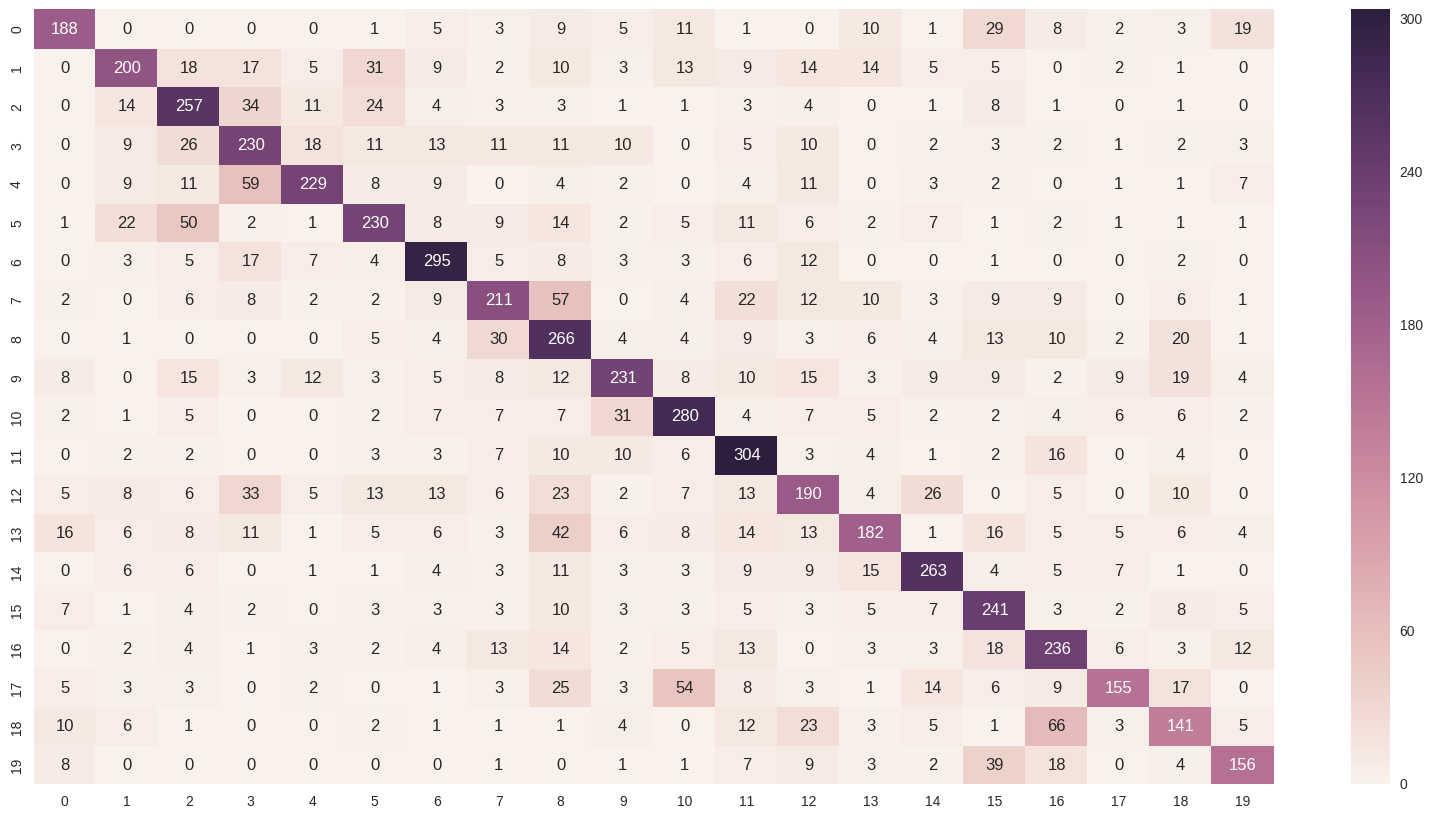

In [42]:
print('Score', pipeline.score(X_test, y_test))
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')
plt.show()

### With just the count vectorizer and Multinomial Naive Bayes, the score is around 65%. What happens if we use ngrams?

In [43]:
pipeline = Pipeline([
    ('count', CountVectorizer(ngram_range=(1, 2))),
    ('mnb', MultinomialNB())
])

In [44]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

Score 0.64899713467


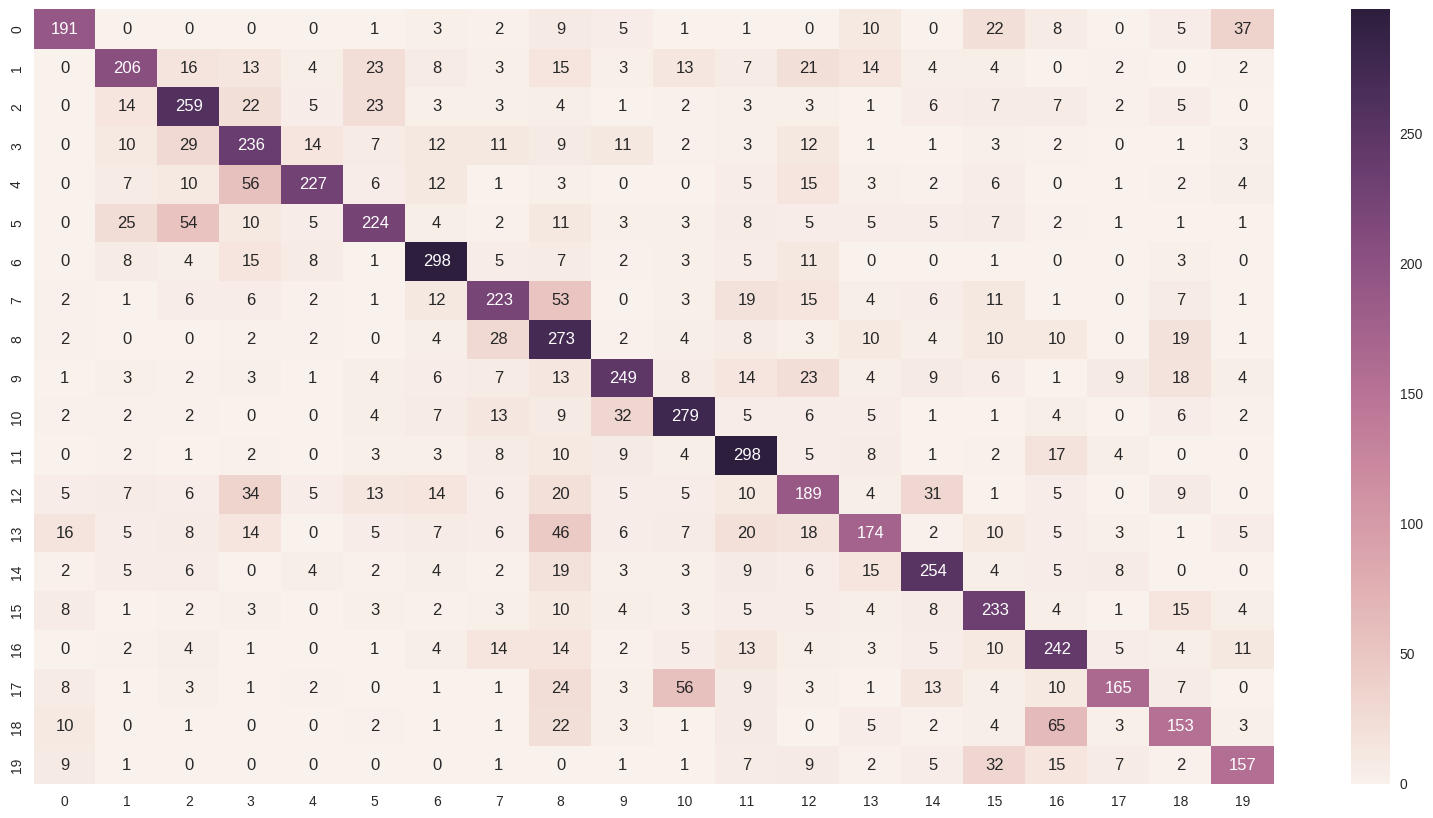

In [45]:
print('Score', pipeline.score(X_test, y_test))
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')
plt.show()

### It's the same... around 65%. So let's try to use the TfidTranformer

In [46]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('mnb', MultinomialNB())
])

In [47]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

Score 0.653868194842


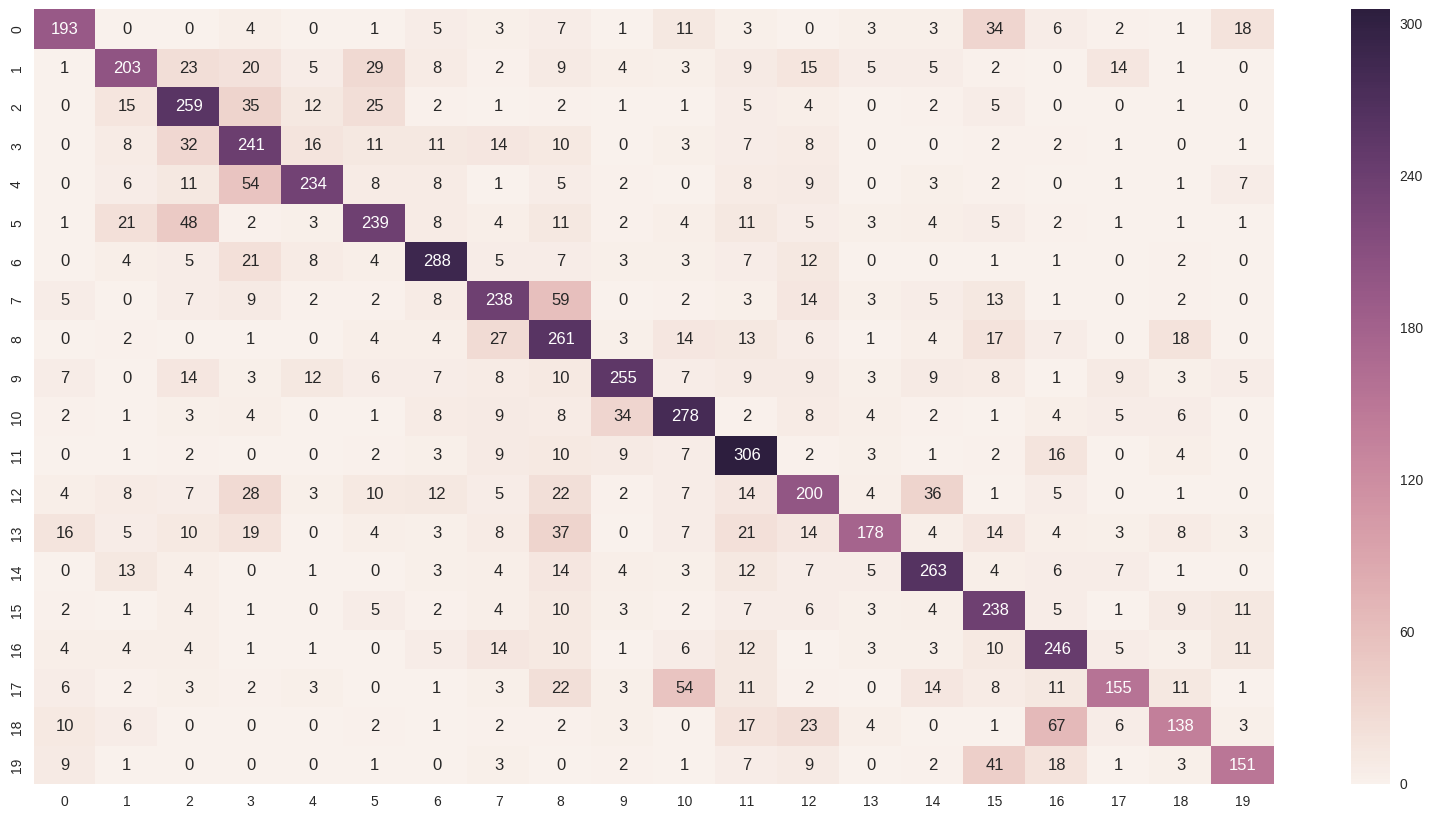

In [48]:
print('Score', pipeline.score(X_test, y_test))
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')
plt.show()

### Again, around 65%... seems like this is as much as we can get by using only this features... so now let's try the same, but with the Text

In [49]:
X_train = train_df['text']
X_test = test_df['text']
y_train = train_df['category']
y_test = test_df['category']

In [50]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [51]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

Score 0.717621776504


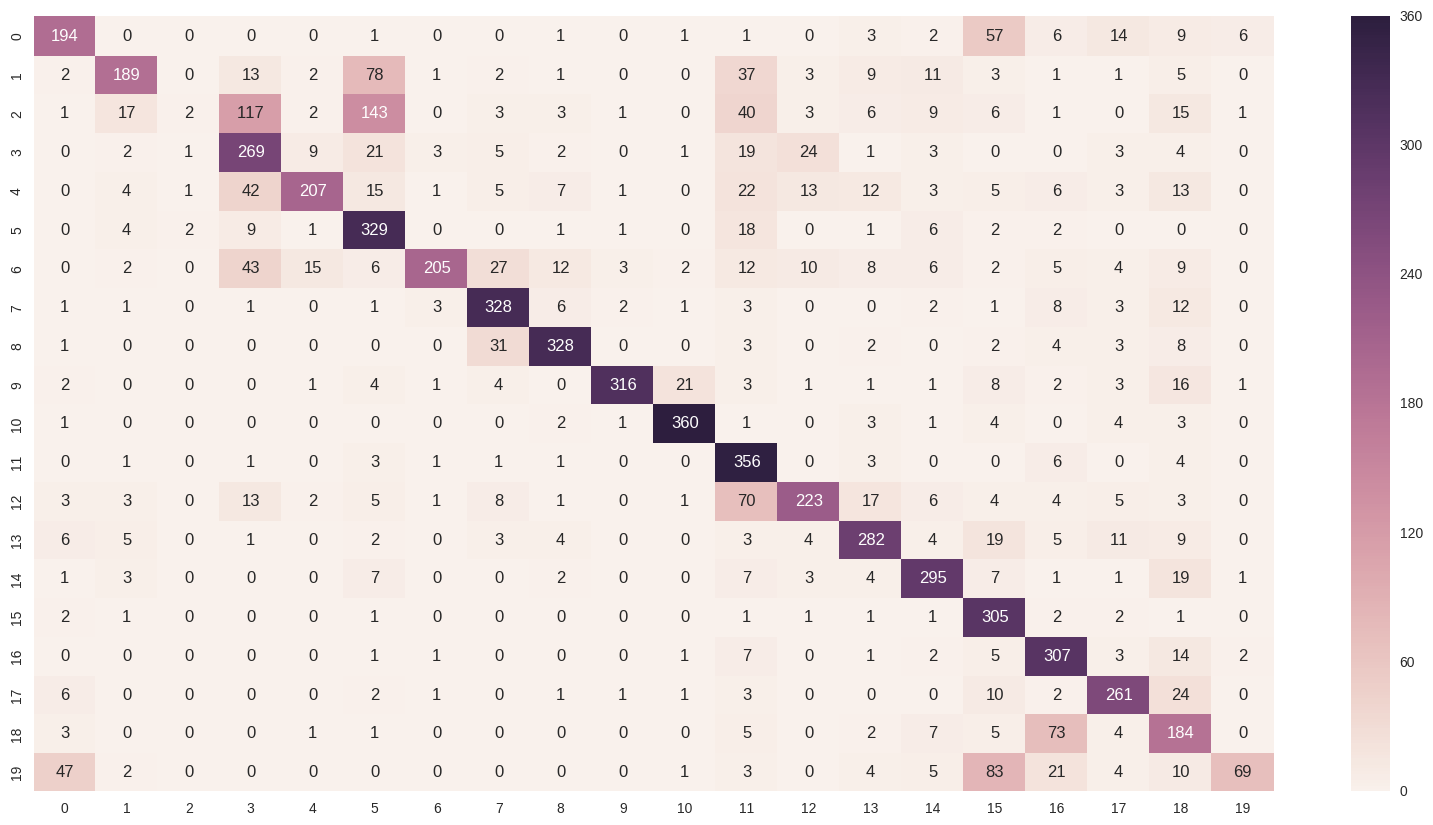

In [52]:
print('Score', pipeline.score(X_test, y_test))
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')
plt.show()

### Now using ngrams

In [53]:
pipeline = Pipeline([
    ('count', CountVectorizer(ngram_range=(1, 2))),
    ('mnb', MultinomialNB())
])

In [54]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

Score 0.665042979943


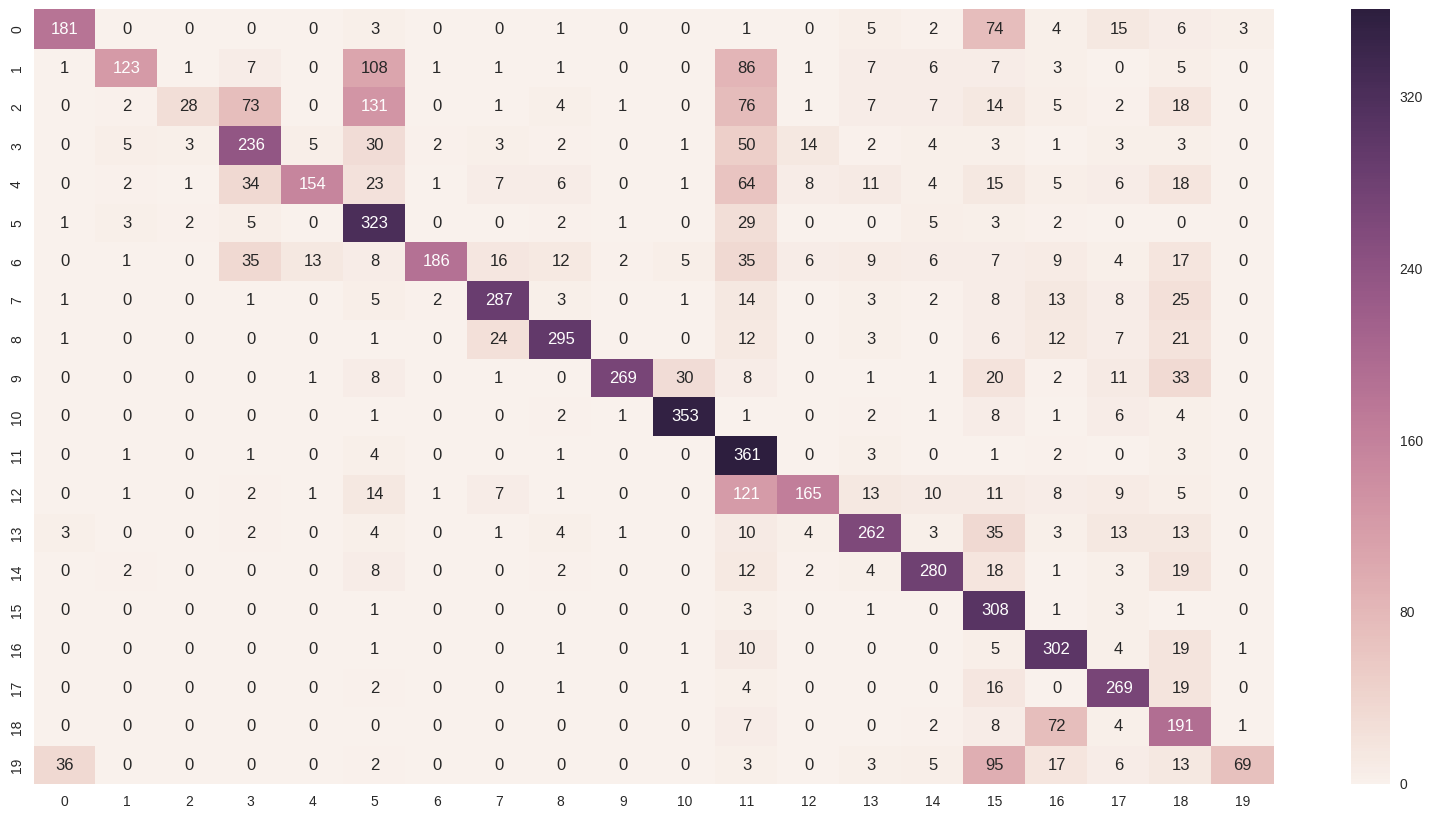

In [55]:
print('Score', pipeline.score(X_test, y_test))
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')
plt.show()

### It actually didn't improve much, but it did take a lot more time to calculate. So let's remove that parameter. 

In [56]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('mnb', MultinomialNB())
])

In [57]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

Score 0.740257879656


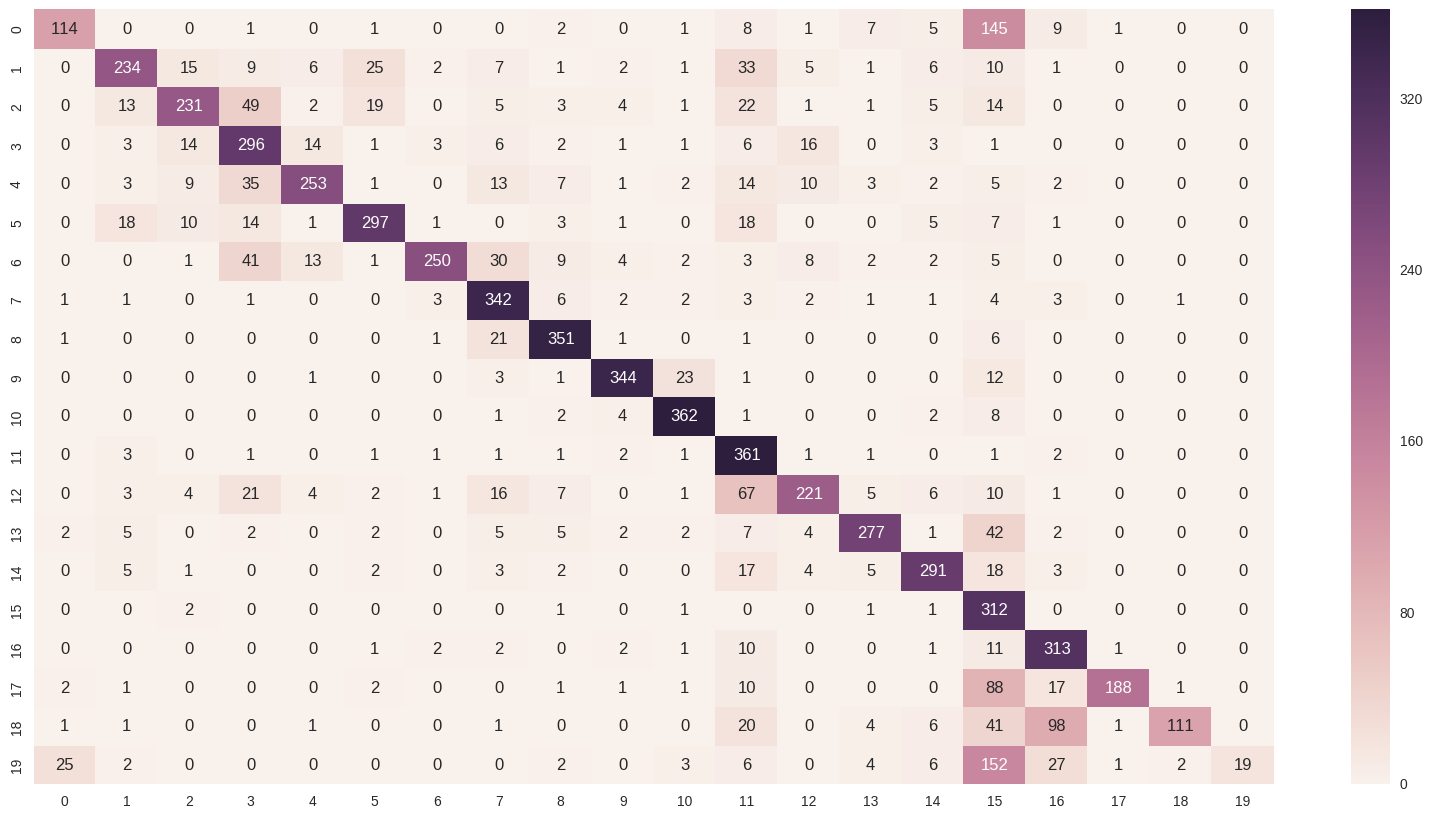

In [58]:
print('Score', pipeline.score(X_test, y_test))
plt.figure(figsize=(20,10))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')
plt.show()

### Se see that there is a lot of confussion with categories 3, 11, 15, 16

In [59]:
# These are the categories
print(train_directories[3])
print(train_directories[11])
print(train_directories[15])
print(train_directories[16])

rec.sport.hockey
sci.crypt
rec.autos
soc.religion.christian


### Could we do something else to the data set, like removing stopwords?

In [50]:
sw = stopwords.words('english')

In [51]:
text = train_df.iloc[0]['text'].split()

In [52]:
clean_text = [word for word in text if word not in sw]

In [53]:
len(text)

1111

In [54]:
len(clean_text)

846